In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

In [2]:
url = f'mysql+pymysql://{env.user}:{env.password}@{env.host}/logs'
df = pd.read_sql('SELECT * FROM api_access', url)
df.head()

,entry
0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...


In [5]:
# function to deal with parsing one entry in our log data
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

In [6]:
df = df.entry.apply(parse_log_entry)
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ip              13974 non-null  object
 1   timestamp       13974 non-null  object
 2   request_method  13974 non-null  object
 3   request_path    13974 non-null  object
 4   http_version    13974 non-null  object
 5   status_code     13974 non-null  object
 6   size            13974 non-null  int64 
 7   user_agent      13974 non-null  object
dtypes: int64(1), object(7)
memory usage: 873.5+ KB


Setting the timestamp as datetime index

In [106]:
#converting to a datetime to analyze dates better
df['timestamp'] = pd.to_datetime(df.timestamp)

In [110]:
#setting index to datetime
df = df.set_index('timestamp').sort_index()

In [111]:
df.head()

,ip,request_method,request_path,http_version,status_code,size,user_agent
timestamp,,,,,,,
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
2019-04-16 19:34:42,97.105.19.58,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2019-04-16 19:34:44,97.105.19.58,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
2019-04-16 19:34:46,97.105.19.58,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
2019-04-16 19:34:48,97.105.19.58,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


## Exploring anomalies in the ip column

In [78]:
df.ip.value_counts()

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
68.201.219.223       21
35.175.171.137        2
70.121.214.34         2
52.87.230.102         2
54.145.52.184         1
52.90.165.200         1
45.23.250.16          1
52.91.30.150          1
35.174.209.2          1
3.92.201.136          1
34.207.64.242         1
54.172.14.223         1
3.88.129.158          1
34.229.70.250         1
Name: ip, dtype: int64

<AxesSubplot:>

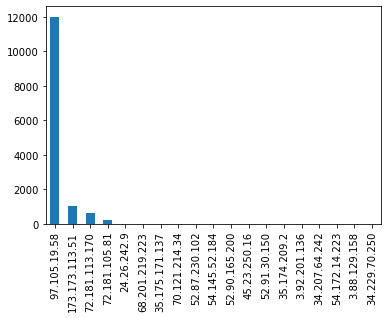

In [80]:
df.ip.value_counts().plot(kind = 'bar')

In [60]:
df[df.ip == '97.105.19.58'].shape[0] / df.shape[0]

0.8585945327035924

The top 4 ip address had way more GET requests than all other users, in fact the top ip address had an order of magnitude more GET requests than then next ip address and in fact was responsible for 86% of all logs. I will investigate the top 2 ip addresses.

**Most common ip address: 97.105.19.58**

In [15]:
df[df.ip == '97.105.19.58'].user_agent.value_counts()

python-requests/2.21.0                                                                                                       10058
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       26
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        2
Python-urllib/3.7                                                                                                                1
Name: user_agent, dtype: int64

In [16]:
df[df.ip == '97.105.19.58'].status_code.value_counts()

200    11984
499       14
Name: status_code, dtype: int64

In [18]:
df[(df.ip == '97.105.19.58') & (df.status_code == '499')]

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
1745,97.105.19.58,16/Apr/2019 19:55:15,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.20.1
1819,97.105.19.58,16/Apr/2019 19:56:02,GET,/api/v1/sales?page=21,HTTP/1.1,499,0,python-requests/2.20.1
4242,97.105.19.58,16/Apr/2019 20:28:46,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0
4405,97.105.19.58,16/Apr/2019 20:33:24,GET,/api/v1/sales?page=29,HTTP/1.1,499,0,python-requests/2.21.0
4790,97.105.19.58,16/Apr/2019 20:38:13,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
4862,97.105.19.58,16/Apr/2019 20:38:55,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
4871,97.105.19.58,16/Apr/2019 20:39:00,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
5520,97.105.19.58,16/Apr/2019 20:45:17,GET,/api/v1/items,HTTP/1.1,499,0,python-requests/2.21.0
5539,97.105.19.58,16/Apr/2019 20:45:28,GET,/api/v1/sales?page=2,HTTP/1.1,499,0,python-requests/2.21.0
6860,97.105.19.58,16/Apr/2019 21:00:35,GET,/api/v1/sales?page=115,HTTP/1.1,499,0,python-requests/2.20.1


All his 499 errors come from a single 1.5 hour timespan

In [20]:
df[df.ip == '97.105.19.58'].request_path.value_counts().head(10)

/api/v1/sales?page=2    698
/api/v1/items           342
/api/v1/items?page=2    179
/api/v1/sales           135
/api/v1/items?page=3    121
/api/v1/stores          100
/                        95
/documentation           93
/api/v1/sales?page=3     81
/api/v1/sales?page=4     73
Name: request_path, dtype: int64

This ip address accessed the /api/v1/sales?page=2 the more than double the next most commonly accessed page.

<AxesSubplot:ylabel='Frequency'>

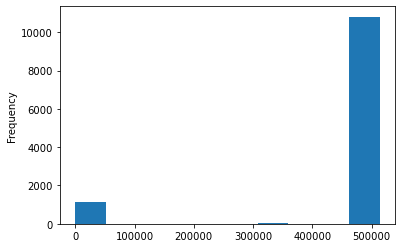

In [82]:
df[df.ip == '97.105.19.58']['size'].plot(kind = 'hist')

The majority of the GET requests pulled about half a megabyte of data each time.

**Looking at the second most common ip address: 173.173.113.51**

In [29]:
df[df.ip == '173.173.113.51'].user_agent.value_counts()

python-requests/2.21.0    1059
Name: user_agent, dtype: int64

In [30]:
df[df.ip == '173.173.113.51'].status_code.value_counts()

200    1059
Name: status_code, dtype: int64

Nothing weird so far 

In [31]:
df[df.ip == '173.173.113.51'].request_path.value_counts().head(10)

/api/v1/items            64
/api/v1/items?page=2     62
/api/v1/items?page=3     62
/api/v1/stores           54
/api/v1/sales             8
/api/v1/sales?page=27     5
/api/v1/sales?page=7      5
/api/v1/sales?page=73     5
/api/v1/sales?page=44     5
/api/v1/sales?page=21     5
Name: request_path, dtype: int64

<AxesSubplot:ylabel='Frequency'>

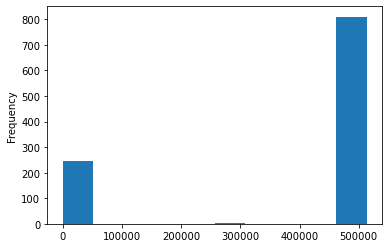

In [32]:
df[df.ip == '173.173.113.51']['size'].plot(kind = 'hist')

Like we saw above the majority of requests pulled about half a megabyte of data.

## Exploring anomalies in the timestamp column

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ip              13974 non-null  object        
 1   timestamp       13974 non-null  datetime64[ns]
 2   request_method  13974 non-null  object        
 3   request_path    13974 non-null  object        
 4   http_version    13974 non-null  object        
 5   status_code     13974 non-null  object        
 6   size            13974 non-null  int64         
 7   user_agent      13974 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 873.5+ KB


<AxesSubplot:xlabel='timestamp', ylabel='Count'>

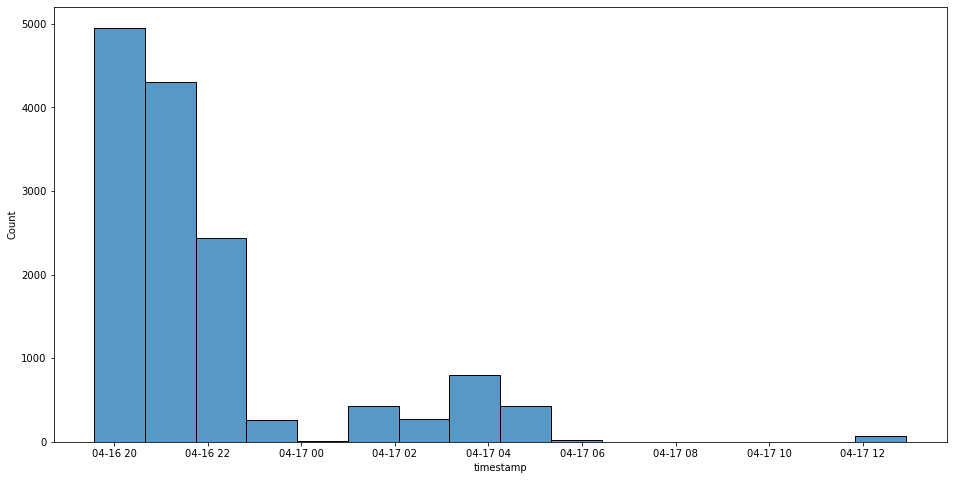

In [119]:
plt.figure(figsize=(16,8))
sns.histplot(data = df, x = df.index, bins = 16)

Checking the range of the times

In [122]:
df.index.min(), df.index.max()

(Timestamp('2019-04-16 19:34:42'), Timestamp('2019-04-17 12:55:14'))

The times of the logs span roughly 15.5 hours

Will now look logs between midnight and 6 AM

In [54]:
df[(df.index > '2019-04-17 00:00:00') & (df.index < '2019-04-17 06:00:00')]

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
11947,72.181.105.81,2019-04-17 00:34:50,GET,/,HTTP/1.1,200,42,python-requests/2.21.0
11948,72.181.105.81,2019-04-17 00:36:58,GET,/documentation,HTTP/1.1,200,348,python-requests/2.21.0
11949,72.181.105.81,2019-04-17 00:40:07,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
11950,72.181.105.81,2019-04-17 00:44:47,GET,/api/v1/items?page=2,HTTP/1.1,200,3659,python-requests/2.21.0
11951,72.181.105.81,2019-04-17 00:45:19,GET,/api/v1/items?page=3,HTTP/1.1,200,1787,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
13883,24.26.242.9,2019-04-17 05:50:21,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,python-requests/2.21.0
13884,24.26.242.9,2019-04-17 05:50:22,GET,/api/v1/sales?page=1,HTTP/1.1,200,493905,python-requests/2.21.0
13885,24.26.242.9,2019-04-17 05:53:32,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0
13886,24.26.242.9,2019-04-17 05:53:32,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,python-requests/2.21.0


In [125]:
df[(df.index > '2019-04-17 00:00:00') & (df.index < '2019-04-17 06:00:00')].shape[0] / df.shape[0]

0.13890081580077288

The logs occurring between midnight and 6 AM account for roughly 10% of all logs. I want to see who is most responsible for these logs. Above I had one ip address that accounted for 86% of all logs, so I hypothesize this same ip address will account for most of the requests betwen midnight and 6 AM.

In [123]:
df[(df.index > '2019-04-17 00:00:00') & (df.index < '2019-04-17 06:00:00')].ip.value_counts()

173.173.113.51    1059
72.181.113.170     613
72.181.105.81      238
68.201.219.223      21
24.26.242.9          6
70.121.214.34        2
52.91.30.150         1
52.87.230.102        1
Name: ip, dtype: int64

I was wrong, and the predicted ip didn't appear at all. I want to investigate that ip's time usage now.

In [126]:
df[(df.index < '2019-04-17 00:00:00') & (df.ip == '97.105.19.58')].index.max()

Timestamp('2019-04-16 22:59:40')

The lastest log comes at roughly 11 PM.

In [127]:
df[(df.index > '2019-04-17 06:00:00') & (df.ip == '97.105.19.58')].index.min()

Timestamp('2019-04-17 12:54:06')

The earliest log comes at roughly 1 PM.

## Exploring anomalies in the request_method column

In [71]:
df.request_method.value_counts()

GET    13974
Name: request_method, dtype: int64

All requests are GET requests.

## Exploring anomalies in the request_path column

In [130]:
df.request_path.value_counts().head(10)

/api/v1/sales?page=2    709
/api/v1/items           464
/api/v1/items?page=2    291
/api/v1/items?page=3    219
/api/v1/stores          162
/api/v1/sales           152
/                       107
/documentation          100
/api/v1/sales?page=3     91
/api/v1/items?page=1     88
Name: request_path, dtype: int64

The single largest amount of requests happen on sales?page=2 

## Exploring anomalies in the http_version column

In [131]:
df.http_version.value_counts()

HTTP/1.1    13974
Name: http_version, dtype: int64

No anomalies

## Exploring anomalies in the status_code column

In [132]:
df.status_code.value_counts()

200    13958
499       16
Name: status_code, dtype: int64

There are 16 requests that result in a 499

## Exploring anomalies in the size column

<AxesSubplot:ylabel='Frequency'>

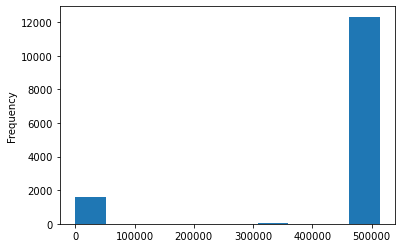

In [134]:
df['size'].plot(kind = 'hist')

Nothing major, just two main groups of data size